Model Surface Output
=============================

Plot an surface map with mean sea level pressure (MSLP),
2m Temperature (F), and Wind Barbs (kt).

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog

Helper functions

In [2]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

Create NCSS object to access the NetcdfSubset
---------------------------------------------
Data from NCEI GFS 0.5 deg Analysis Archive

In [3]:
# Specify our date/time of product desired
dt = datetime(2018, 1, 4, 12)

# Construct the URL for our THREDDS Data Server Catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-gfs-g4-anl-files-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2'].subset()

# Create our NCSS query with desired specifications
query = ncss.query()
query.time(dt)
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf')
query.variables('Pressure_reduced_to_MSL_msl',
                'Apparent_temperature_height_above_ground',
                'u-component_of_wind_height_above_ground',
                'v-component_of_wind_height_above_ground')

# Obtain the data we've queried for
data = ncss.get_data(query)

Begin data maipulation
-----------------------
Data for the surface from a model is a bit complicated.
The variables come from different levels and may have different data array shapes.

MSLP: Pressure_reduced_to_MSL_msl (time, lat, lon)
2m Temp: Apparent_temperature_height_above_ground (time, level, lat, lon)
10m Wind: u/v-component_of_wind_height_above_ground (time, level, lat, lon)

Height above ground Temp from GFS has one level (2m)
Height above ground Wind from GFS has three levels (10m, 80m, 100m)

In [4]:
# Pull out variables you want to use
mslp = data.variables['Pressure_reduced_to_MSL_msl'][:].squeeze()
temp = units.K * data.variables['Apparent_temperature_height_above_ground'][:].squeeze()
u_wind = units('m/s') * data.variables['u-component_of_wind_height_above_ground'][:].squeeze()
v_wind = units('m/s') * data.variables['v-component_of_wind_height_above_ground'][:].squeeze()
lat = data.variables['lat'][:].squeeze()
lon = data.variables['lon'][:].squeeze()
time_var = data.variables[find_time_var(data.variables['Pressure_reduced_to_MSL_msl'])]

# Convert winds to knots
u_wind.ito('kt')
v_wind.ito('kt')

# Convert number of hours since the reference time into an actual date
time = num2pydate(time_var[:].squeeze(), time_var.units)

lev_10m = np.where(data.variables['height_above_ground3'][:] == 10)[0][0]
u_wind_10m = u_wind[lev_10m]
v_wind_10m = v_wind[lev_10m]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth MSLP a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
smooth_mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0) * units.Pa
smooth_mslp.ito('hPa')

Begin map creation
------------------

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


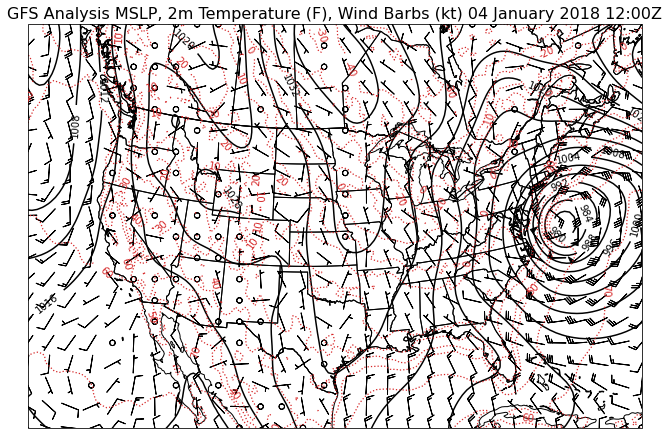

In [5]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(11, 8.5))

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)
plt.title('GFS Analysis MSLP, 2m Temperature (F), Wind Barbs (kt)'
          f' {time:%d %B %Y %H:%MZ}', fontsize=16)
ax.set_extent([235., 290., 20., 55.])

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lakes',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot MSLP Contours
clev_mslp = np.arange(0, 1200, 4)
cs = ax.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 2m Temperature Contours
clevtemp = np.arange(-60, 101, 10)
cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
                 colors='tab:red', linewidths=1.25, linestyles='dotted',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 10m Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_10m.magnitude, v_wind_10m.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)